# Week 12 — Regularization at Scale

This notebook covers regularization techniques for deep models. You'll:
- Implement and compare dropout, weight decay, and data augmentation
- Design rigorous ablation experiments
- Build ensemble models
- Measure generalization improvements

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0+cpu


In [ ]:

import os, pickle
import torch

CACHE_DIR = "cache_week16"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

def save_model(model, name):
    torch.save(model.state_dict(), os.path.join(CACHE_DIR, f"{name}.pth"))

def load_model_state(name):
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    return torch.load(path, weights_only=True) if os.path.exists(path) else None

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week12


## 1. Dropout Regularization

[cache] loaded 'dropout_comparison_5epochs'


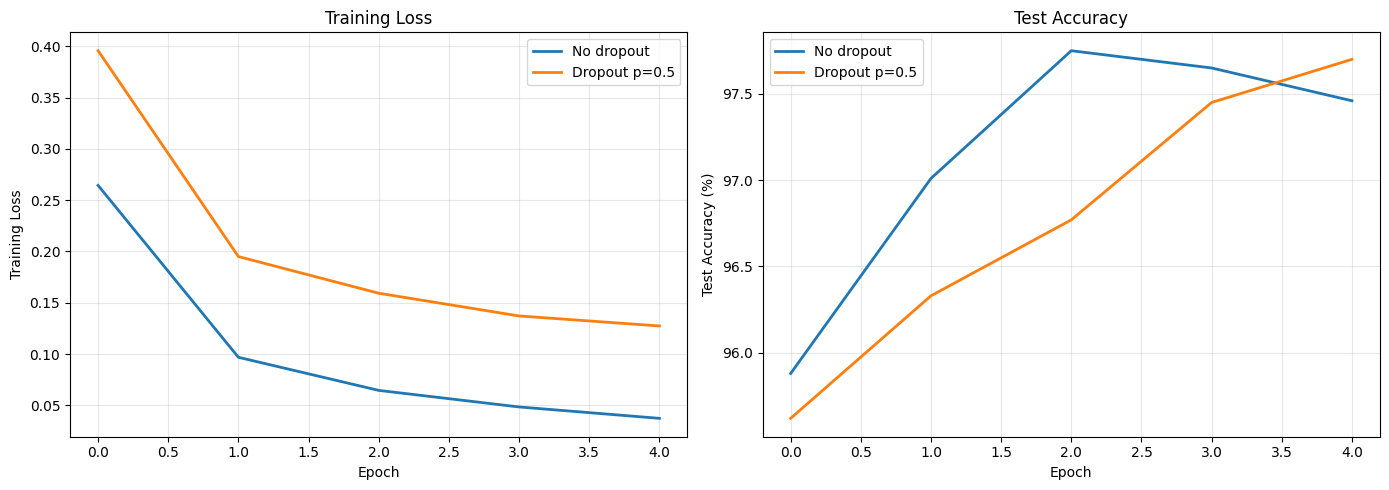

In [26]:

import torchvision.transforms as transforms
import torchvision.datasets as datasets

class MLPWithDropout(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=10, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_p)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x));  x = self.dropout1(x)
        x = self.relu(self.fc2(x));  x = self.dropout2(x)
        return self.fc3(x)

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False,               transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64, shuffle=False)

def train_and_evaluate(model, train_loader, test_loader, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_accs = [], []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = sum(
            (lambda: (optimizer.zero_grad(), (loss := criterion(model(d), t)),
                      loss.backward(), optimizer.step(), loss.item())[-1])()
            for d, t in train_loader)
        train_losses.append(epoch_loss / len(train_loader))
        model.eval()
        correct = sum(model(d).argmax(dim=1).eq(t).sum().item()
                      for d, t in (torch.no_grad(), test_loader)[1])
        test_accs.append(100. * correct / len(test_dataset))
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Test Acc={test_accs[-1]:.2f}%")
    return train_losses, test_accs

# --- cleaner version (same logic, more readable) ---
def _train_eval(model, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    tr_losses, te_accs = [], []
    for ep in range(n_epochs):
        model.train()
        ep_loss = 0.0
        for d, t in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(d), t)
            loss.backward(); optimizer.step()
            ep_loss += loss.item()
        tr_losses.append(ep_loss / len(train_loader))
        model.eval()
        correct = 0
        with torch.no_grad():
            for d, t in test_loader:
                correct += model(d).argmax(1).eq(t).sum().item()
        te_accs.append(100. * correct / len(test_dataset))
        print(f"  Epoch {ep+1}: Loss={tr_losses[-1]:.4f}, Acc={te_accs[-1]:.2f}%")
    return tr_losses, te_accs

def _dropout_comparison():
    print("Training WITHOUT dropout...")
    m0 = MLPWithDropout(dropout_p=0.0)
    l0, a0 = _train_eval(m0)
    print("\nTraining WITH dropout (p=0.5)...")
    m1 = MLPWithDropout(dropout_p=0.5)
    l1, a1 = _train_eval(m1)
    return l0, a0, l1, a1

losses_no_drop, accs_no_drop, losses_drop, accs_drop = cached(
    "dropout_comparison_5epochs", _dropout_comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(losses_no_drop, label='No dropout', linewidth=2)
axes[0].plot(losses_drop,    label='Dropout p=0.5', linewidth=2)
axes[0].set(xlabel='Epoch', ylabel='Training Loss', title='Training Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(accs_no_drop, label='No dropout', linewidth=2)
axes[1].plot(accs_drop,    label='Dropout p=0.5', linewidth=2)
axes[1].set(xlabel='Epoch', ylabel='Test Accuracy (%)', title='Test Accuracy')
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()


## 2. Data Augmentation

In [27]:

transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

def _augmentation_experiment():
    train_aug = DataLoader(
        datasets.MNIST('./data', train=True, download=True, transform=transform_augmented),
        batch_size=64, shuffle=True)
    print("Training WITH data augmentation...")
    m = MLPWithDropout(dropout_p=0.0)
    losses, accs = _train_eval(m, n_epochs=5)
    return losses, accs

losses_aug, accs_aug = cached("augmentation_experiment_5epochs", _augmentation_experiment)

print(f"Final test accuracy (no augmentation): {accs_no_drop[-1]:.2f}%")
print(f"Final test accuracy (with augmentation): {accs_aug[-1]:.2f}%")


[cache] loaded 'augmentation_experiment_5epochs'
Final test accuracy (no augmentation): 97.46%
Final test accuracy (with augmentation): 98.05%


## 3. Weight Decay (L2 Regularization)

[cache] loaded 'weight_decay_sweep_5epochs'


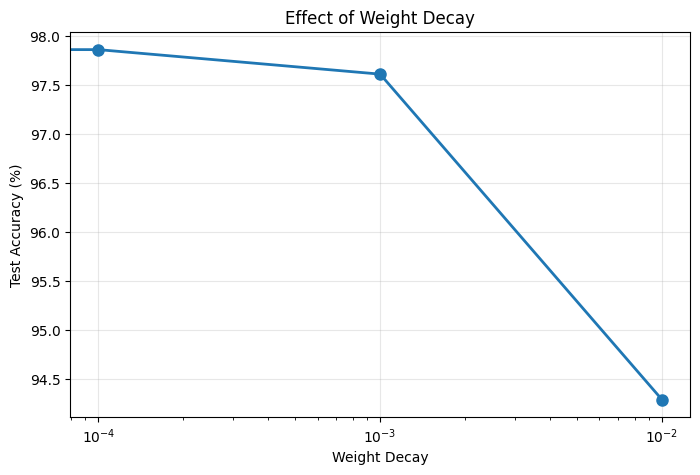

In [28]:

weight_decays = [0.0, 1e-4, 1e-3, 1e-2]

def _wd_sweep():
    results = {}
    for wd in weight_decays:
        print(f"  Training with weight_decay={wd}...")
        m = MLPWithDropout(dropout_p=0.0)
        crit = nn.CrossEntropyLoss()
        opt  = optim.Adam(m.parameters(), lr=0.001, weight_decay=wd)
        for _ in range(5):
            m.train()
            for d, t in train_loader:
                opt.zero_grad()
                loss = crit(m(d), t)
                loss.backward(); opt.step()
        m.eval()
        correct = sum(m(d).argmax(1).eq(t).sum().item() for d, t in test_loader)
        acc = 100. * correct / len(test_dataset)
        results[wd] = acc
        print(f"    Test accuracy: {acc:.2f}%")
    return results

wd_results = cached("weight_decay_sweep_5epochs", _wd_sweep)

plt.figure(figsize=(8, 5))
plt.plot(list(wd_results.keys()), list(wd_results.values()), 'o-', linewidth=2, markersize=8)
plt.xlabel('Weight Decay'); plt.ylabel('Test Accuracy (%)')
plt.title('Effect of Weight Decay'); plt.xscale('log'); plt.grid(alpha=0.3); plt.show()


## 4. Ensemble Methods

In [29]:

n_models = 5

def _train_ensemble():
    models_state = []
    for i in range(n_models):
        torch.manual_seed(i)
        m = MLPWithDropout(dropout_p=0.3)
        crit = nn.CrossEntropyLoss()
        opt  = optim.Adam(m.parameters(), lr=0.001)
        for _ in range(3):
            m.train()
            for d, t in train_loader:
                opt.zero_grad()
                loss = crit(m(d), t)
                loss.backward(); opt.step()
        models_state.append(m.state_dict())
        print(f"  Model {i+1} trained")
    return models_state

ensemble_states = cached("ensemble_5models_3epochs", _train_ensemble)

ensemble_models = []
for state in ensemble_states:
    m = MLPWithDropout(dropout_p=0.3)
    m.load_state_dict(state); m.eval()
    ensemble_models.append(m)

def ensemble_predict(models, data):
    with torch.no_grad():
        avg = torch.stack([m(data) for m in models]).mean(0)
    return avg.argmax(1)

correct_ens, correct_single = 0, 0
for d, t in test_loader:
    correct_ens    += ensemble_predict(ensemble_models, d).eq(t).sum().item()
    correct_single += ensemble_models[0](d).argmax(1).eq(t).sum().item()

acc_ens    = 100. * correct_ens    / len(test_dataset)
acc_single = 100. * correct_single / len(test_dataset)
print(f"Single model accuracy: {acc_single:.2f}%")
print(f"Ensemble accuracy:     {acc_ens:.2f}%")
print(f"Improvement:           {acc_ens - acc_single:.2f}%")


[cache] loaded 'ensemble_5models_3epochs'
Single model accuracy: 97.85%
Ensemble accuracy:     97.99%
Improvement:           0.14%


## Exercises

1. **BatchNorm + Dropout**: Combine BatchNorm and Dropout and compare
2. **Ablation Tables**: Create comprehensive ablation tables for all regularization methods
3. **Augmentation Study**: Try different augmentation strategies and measure effects
4. **Real Dataset**: Apply to CIFAR-10 or similar

## Deliverables

- [ ] Dropout experiments with validation curves
- [ ] Data augmentation study
- [ ] Weight decay comparison
- [ ] Ensemble model implementation
- [ ] Ablation table with clear recommendations

In [30]:

# EXERCISE 1 — BatchNorm + Dropout Interaction
# Goal: add BatchNorm1d after each hidden layer in MLPWithDropout.
# Test all 4 combos: (BN off/on) × (Dropout off/on). Report test accuracy.
# Use cached(f"bn{bn}_drop{dp}_5epochs", ...) for each combo.
# Expected insight: BatchNorm + Dropout can conflict — the recommended order matters.


In [31]:

# EXERCISE 3 — Comprehensive Ablation Table
# Goal: train 9 models (all combos of dropout∈{0,0.3,0.5} × wd∈{0,1e-4,1e-3})
# for 5 epochs on MNIST. Record test accuracy in a 3×3 table (use pandas DataFrame).
# Use cached(f"ablation_dp{dp}_wd{wd}", ...) per cell.
# Deliverable: print the DataFrame and identify the best regularization combo.


In [32]:

# EXERCISE 4 — Early Stopping as Implicit Regularization
# Goal: implement a training loop with early stopping (patience=5, monitor val_loss).
# Train a model without explicit dropout/weight-decay; stop when val_loss stops improving.
# Use cached("early_stopping_run", ...) to store (best_epoch, best_val_acc, history).
# Compare stopped epoch vs. full-run epoch and explain the regularization effect.
